<a href="https://colab.research.google.com/github/kamantina/projectreport/blob/main/feature_analysis/video_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nouns

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/CISC7298/videos_202500308_utf8_filtered_isEnglish2_2050_LIWC_pmi200-10-4.csv', encoding='utf-8')

In [ ]:
# Ensure that 'tags' are strings (if they're lists or other formats)
df['tags'] = df['tags'].astype(str)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Combine titles and tags into a single text field
df['combined_text'] = df['title'].fillna('') + ' ' + df['tags'].fillna('')

In [ ]:
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Removing stop words
    doc = nlp(text)
    meaningful_words = [token.text for token in doc if token.text not in STOP_WORDS]
    # Lemmatization
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

# Applying preprocessing to the combined text field
df['preprocessed_text'] = df['combined_text'].apply(preprocess_text)

In [ ]:
# Extract nouns
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return nouns

df['nouns'] = df['preprocessed_text'].apply(extract_nouns)

In [ ]:
# Function to remove repeating nouns
def remove_repeats(nouns):
    return list(set(nouns))

In [ ]:
import ast

# Convert strings of lists back into actual lists if necessary
df['nouns'] = df['nouns'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now apply the remove_repeats function
df['unique_nouns'] = df['nouns'].apply(remove_repeats)

# Topic Modelling

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    return ' '.join(tokens)

# Assuming your data is loaded into a DataFrame 'df'
df['metadata_text'] = df['title'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['tags'].fillna('')
df['metadata_text'] = df['metadata_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_metadata = CountVectorizer()
dtm_metadata = vectorizer_metadata.fit_transform(df['metadata_text'])


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_metadata = LatentDirichletAllocation(n_components=15, random_state=42)
lda_metadata.fit(dtm_metadata)


LatentDirichletAllocation(n_components=15, random_state=42)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[idx] = topic_words
    return topics

no_top_words = 30
feature_names_metadata = vectorizer_metadata.get_feature_names_out()
metadata_topics = display_topics(lda_metadata, feature_names_metadata, no_top_words)


In [ ]:
for topic_idx, topic_words in metadata_topics.items():
    print(f"Topic {topic_idx}: {', '.join(topic_words)}\n")

Topic 0: music, ambient, meditation, sleep, relaxing, relaxation, cyberpunk, channel, deep, fantasy, study, slime, copyright, ancient, focus, video, reading, egyptian, soothing, calm, city, soundtrack, ethereal, runner, blade, relax, studying, satisfying, chill, find

Topic 1: ambience, asmr, harry, potter, hogwarts, sound, channel, enjoy, study, get, also, lot, video, music, inspired, early, commonly, sleep, exclusive, subscribe, patreon, room, rain, lord, relaxing, like, world, relax, ring, instagram

Topic 2: asmr, ambience, ghibli, study, castle, howl, studio, moving, spaceship, music, love, etc, spirited, hour, comment, away, video, sleep, chill, one, soft, eating, much, day, help, appreciate, singing, watching, question, dream

Topic 3: rain, ambience, jurassic, cyberpunk, park, study, ship, dinosaur, night, video, ambient, neheart, city, tokyo, jungle, ocean, asmr, sea, sound, music, wave, futuristic, revengers, 2077, supernatural, black, avenger, relax, channel, shifting

Topic

In [ ]:
# Get the topic distribution for each document
topic_distributions = lda_metadata.transform(dtm_metadata)


In [ ]:
import numpy as np

# Get the dominant topic for each document
dominant_topics = np.argmax(topic_distributions, axis=1)

# Add the dominant topic to your DataFrame
df['dominant_topic'] = dominant_topics


In [ ]:
# Create a DataFrame from the topic distributions
topic_names = [f'Topic {i}' for i in range(lda_metadata.n_components)]
df_topic_scores = pd.DataFrame(topic_distributions, columns=topic_names)

# Combine with your original DataFrame
df = pd.concat([df.reset_index(drop=True), df_topic_scores], axis=1)

In [ ]:
topic_counts = df['dominant_topic'].value_counts()

print("Topic Distribution:")
print(topic_counts)


Topic Distribution:
dominant_topic
13    356
4     210
7      93
1      75
9      42
0      38
2      33
8      29
12     26
3      23
6      22
14     18
10     17
11     15
5       6
Name: count, dtype: int64


In [ ]:
# Group by dominant topic and calculate mean metrics
# topic_engagement = df.groupby('dominant_topic')[['viewCount', 'likeCount', 'commentCount']].mean()
topic_engagement = df.groupby('dominant_topic')[['likeCount', 'commentCount']].mean()

print("Average Engagement Metrics per Topic:")
print(topic_engagement)


Average Engagement Metrics per Topic:
                   likeCount  commentCount
dominant_topic                            
0               29874.105263   1092.578947
1               19597.013514    288.440000
2               18424.468750    664.636364
3               14852.956522    346.956522
4               32632.352381   1017.338095
5               79823.166667   1789.000000
6               56606.190476   1570.181818
7               22961.677419    557.161290
8                7309.206897    263.034483
9               29216.000000   1091.071429
10               8326.470588    263.882353
11              22599.200000    726.866667
12              26080.318182    894.807692
13              27561.959654    860.744382
14              29594.000000    774.555556


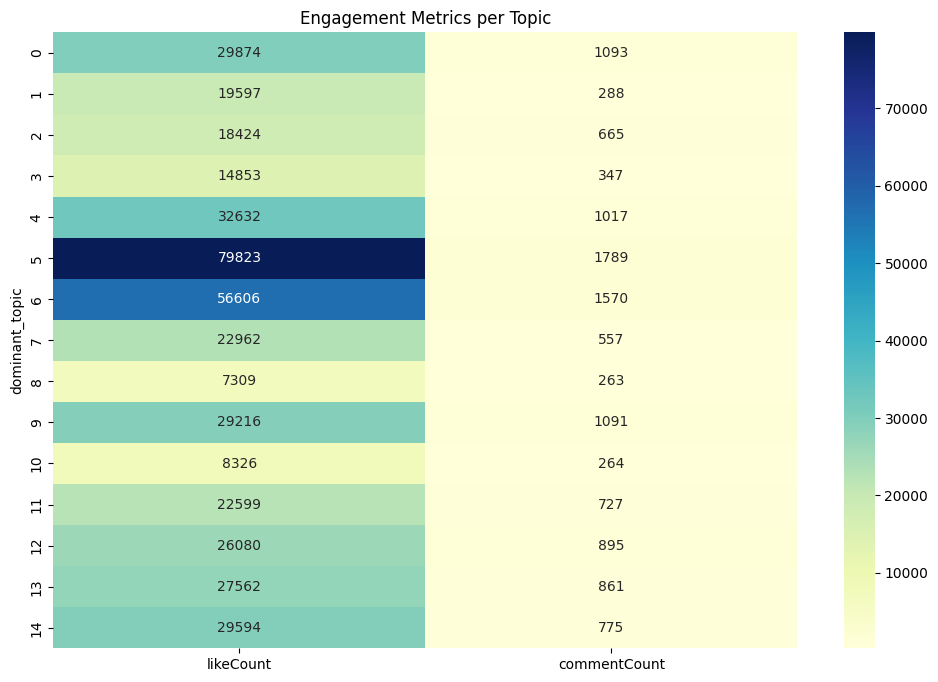

In [ ]:
import seaborn as sns

# Heatmap of engagement metrics per topic
plt.figure(figsize=(12, 8))
sns.heatmap(topic_engagement, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Engagement Metrics per Topic')
plt.show()


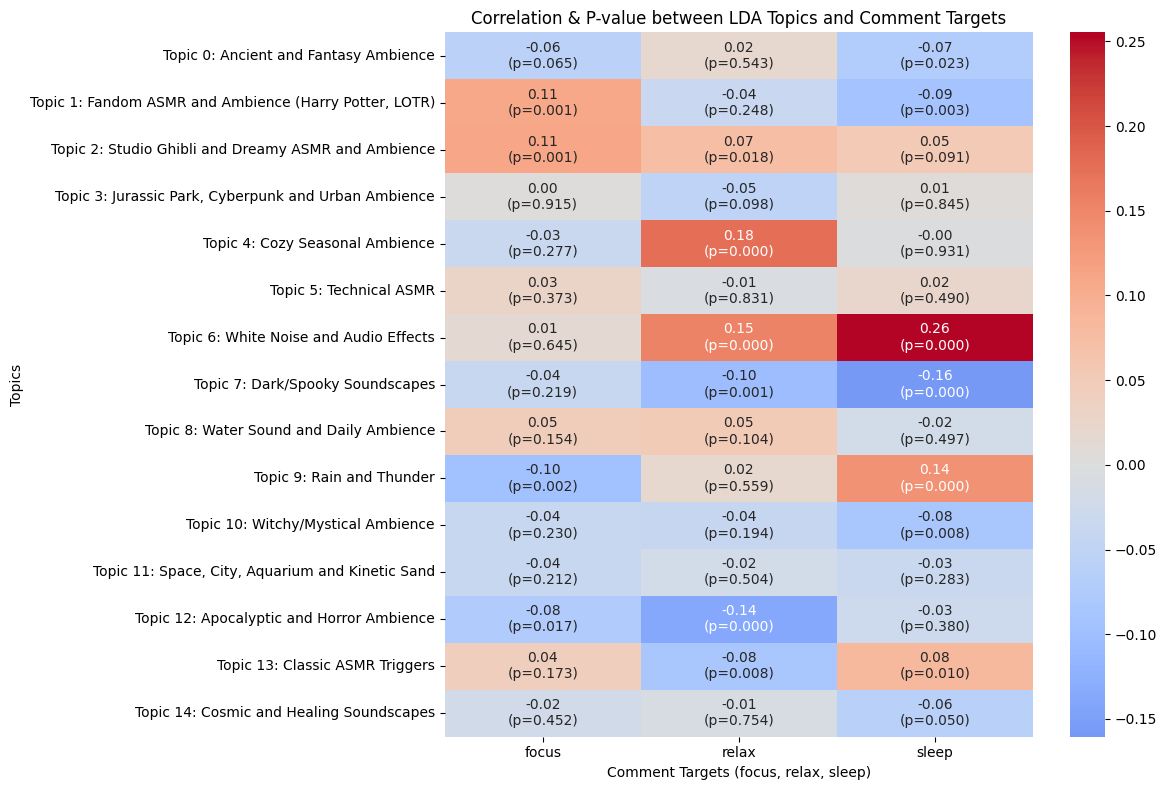

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming these are your defined column names:
topic_columns = [f"Topic {i}" for i in range(15)]
target_columns = ["focus", "relax", "sleep"]

# Calculate the correlation matrix for your topics and targets.
corr_matrix = df[topic_columns + target_columns].corr().loc[topic_columns, target_columns]

# Create an empty DataFrame to hold p-values.
pval_matrix = pd.DataFrame(index=topic_columns, columns=target_columns)

# Loop through topic-target pairs to calculate p-values.
for topic in topic_columns:
    for target in target_columns:
        r, p = pearsonr(df[topic], df[target])
        pval_matrix.loc[topic, target] = p

# Convert p-values to floats
pval_matrix = pval_matrix.astype(float)

# Create a custom annotation matrix that combines r and p.
annotations = np.empty(corr_matrix.shape, dtype=object)
for i, topic in enumerate(topic_columns):
    for j, target in enumerate(target_columns):
        r = corr_matrix.loc[topic, target]
        p = pval_matrix.loc[topic, target]
        annotations[i, j] = f"{r:.2f}\n(p={p:.3f})"

# Your custom topic names in the order corresponding to Topic 0, Topic 1, etc.
topic_labels = [
    "Topic 0: Ancient and Fantasy Ambience",
    "Topic 1: Fandom ASMR and Ambience (Harry Potter, LOTR)",
    "Topic 2: Studio Ghibli and Dreamy ASMR and Ambience",
    "Topic 3: Jurassic Park, Cyberpunk and Urban Ambience",
    "Topic 4: Cozy Seasonal Ambience",
    "Topic 5: Technical ASMR",
    "Topic 6: White Noise and Audio Effects",
    "Topic 7: Dark/Spooky Soundscapes",
    "Topic 8: Water Sound and Daily Ambience",
    "Topic 9: Rain and Thunder",
    "Topic 10: Witchy/Mystical Ambience",
    "Topic 11: Space, City, Aquarium and Kinetic Sand",
    "Topic 12: Apocalyptic and Horror Ambience",
    "Topic 13: Classic ASMR Triggers",
    "Topic 14: Cosmic and Healing Soundscapes"
]

# Plotting the heatmap with yticklabels set to our custom labels
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=annotations,
    fmt="",
    cmap="coolwarm",
    center=0,
    yticklabels=topic_labels  # Replace axis labels here
)
plt.title("Correlation & P-value between LDA Topics and Comment Targets")
plt.xlabel("Comment Targets (focus, relax, sleep)")
plt.ylabel("Topics")
plt.tight_layout()
plt.show()


Save the file with video features on nouns and topics

In [ ]:
df.to_csv('videos_202500308_utf8_filtered_isEnglish2_2050_LIWC_pmi200-10-4_nouns_lda15.csv', index=False)